
# Aggregate LRT JSON → Chi-square Comparison (REF vs DATA)

This notebook scans your output tree for `lrt_outputs.json` under both:
- `calibration/toy_*/lrt_outputs.json` (REF)
- `comparison/toy_*/lrt_outputs.json` (DATA)

It builds the two distributions from the `test` field and plots them.


In [4]:

import os, glob, json, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, chi2
import re
from pathlib import Path

# --- Style to match your example ---
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

# --- User config ---
BASE_DIR = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_trial"    # <- set this to the base folder containing calibration/ and comparison/
FIG_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(FIG_DIR, exist_ok=True)

# Defaults mirroring your example
NBINS   = 30
XMIN    = 0
XMAX    = 300
YMAX    = None
PRINT_Z = True

# If None, df is set to mean(REF); otherwise use a fixed number
DF_OVERRIDE = None


In [5]:
def _as_scalar_test(x):
    """Convert JSON 'test' to a float. If list or array, sum it."""
    if isinstance(x, (int, float)):
        return float(x)
    if isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            return float("nan")
        try:
            return float(np.nansum(np.asarray(x, dtype=float)))
        except Exception:
            return float("nan")
    return float("nan")


def _collect_mode_tests(base_dir, mode):
    """Return a 1D numpy array of toy-level test values for a mode."""
    patt = os.path.join(base_dir, mode, "toy_*", "lrt_outputs.json")
    tests = []
    for fp in sorted(glob.glob(patt)):
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            t = _as_scalar_test(obj.get("test"))
            if np.isfinite(t):
                tests.append(t)
        except Exception:
            pass
    return np.asarray(tests, dtype=float)


Saved figure to: /work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_trial/plots/probability_plot.pdf


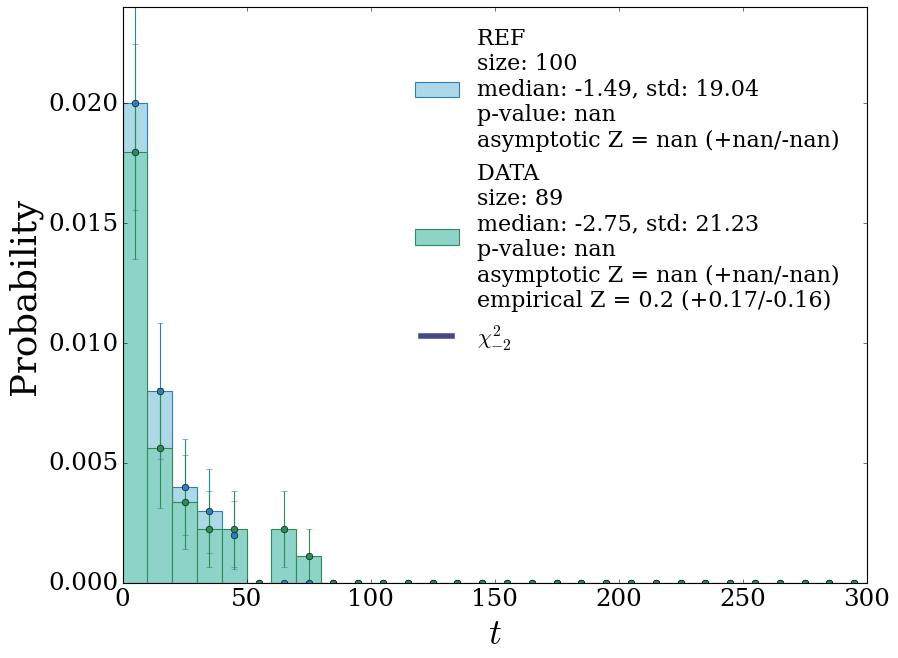

In [6]:
def Z_score_chi2(t, df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z, sf


def plot_2distribution_like_example(
    t1, t2, df, output_path, xmin=0, xmax=300, ymax=None, nbins=10,
    save=True, label1='REF', label2='DATA', save_name='probability_plot', print_Zscore=True
):
    """Same look as your example: fonts 32,22, colors, legend, chi2 overlay."""
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')

    bins = np.linspace(xmin, xmax, nbins + 1)
    binswidth = (xmax - xmin) / nbins

    # REF
    Z_obs, p_value_obs = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533 * np.std(t1) / np.sqrt(t1.shape[0])
    Z_obs_p, _ = Z_score_chi2(np.median(t1) + t_obs_err, df)
    Z_obs_m, _ = Z_score_chi2(np.median(t1) - t_obs_err, df)
    label = '%s \nsize: %i\nmedian: %s, std: %s\np-value: %s\n' % (
        label1, t1.shape[0], str(np.around(np.median(t1), 2)),
        str(np.around(np.std(t1), 2)), str(np.around(p_value_obs, 5))
    )
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)' % (
            str(np.around(Z_obs, 2)),
            str(np.around(Z_obs_p - Z_obs, 2)),
            str(np.around(Z_obs - Z_obs_m, 2))
        )

    h1 = plt.hist(
        t1, weights=np.ones_like(t1) / (t1.shape[0] * binswidth),
        color='lightblue', ec='#2c7fb8', bins=bins, label=label
    )
    err1 = np.sqrt(h1[0] / (t1.shape[0] * binswidth))
    xcenters = 0.5 * (bins[1:] + bins[:-1])
    plt.errorbar(xcenters, h1[0], yerr=err1, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h1[0]) if len(h1[0]) else 0.0

    # DATA
    max2 = 0.0
    if len(t2):
        Z_obs2, p_value_obs2 = Z_score_chi2(np.median(t2), df)
        t_obs_err2 = 1.2533 * np.std(t2) / np.sqrt(t2.shape[0])
        Z_obs_p2, _ = Z_score_chi2(np.median(t2) + t_obs_err2, df)
        Z_obs_m2, _ = Z_score_chi2(np.median(t2) - t_obs_err2, df)

        t_empirical = np.sum(1.0 * (t1 > np.mean(t2))) / t1.shape[0]
        empirical_lim = '='
        if t_empirical == 0:
            empirical_lim = '>'
            t_empirical = 1.0 / t1.shape[0]
        t_empirical_err = t_empirical * np.sqrt(1.0 / (np.sum(1.0 * (t1 > np.mean(t2))) + 1.0 / t1.shape[0]))
        Z_empirical   = norm.ppf(1 - t_empirical)
        Z_empirical_m = norm.ppf(1 - (t_empirical + t_empirical_err))
        Z_empirical_p = norm.ppf(1 - (t_empirical - t_empirical_err))

        label = '%s \nsize: %i\nmedian: %s, std: %s\np-value: %s\n' % (
            label2, t2.shape[0], str(np.around(np.median(t2), 2)),
            str(np.around(np.std(t2), 2)), str(np.around(p_value_obs2, 5))
        )
        if print_Zscore:
            label += 'asymptotic Z = %s (+%s/-%s) \n' % (
                str(np.around(Z_obs2, 2)),
                str(np.around(Z_obs_p2 - Z_obs2, 2)),
                str(np.around(Z_obs2 - Z_obs_m2, 2))
            )
            label += 'empirical Z %s %s (+%s/-%s)' % (
                empirical_lim,
                str(np.around(Z_empirical, 2)),
                str(np.around(Z_empirical_p - Z_empirical, 2)),
                str(np.around(Z_empirical - Z_empirical_m, 2))
            )

        h2 = plt.hist(
            t2, weights=np.ones_like(t2) / (t2.shape[0] * binswidth),
            color='#8dd3c7', ec='seagreen', bins=bins, label=label
        )
        err2 = np.sqrt(h2[0] / (t2.shape[0] * binswidth))
        plt.errorbar(xcenters, h2[0], yerr=err2, color='seagreen', marker='o', ls='')
        max2 = np.max(h2[0]) if len(h2[0]) else 0.0

    # chi2 reference
    xgrid = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(xgrid, chi2.pdf(xgrid, df), 'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$' % (df))

    font = font_manager.FontProperties(family='serif', size=20)
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2 * max(max1, max2))
    if ymax is not None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")

    if save:
        fn = os.path.join(output_path, save_name + '.pdf')
        plt.savefig(fn, bbox_inches="tight")
        print("Saved figure to:", fn)
    plt.show()
    plt.close()


if __name__ == "__main__":
    t_ref = _collect_mode_tests(BASE_DIR, "calibration")
    t_data = _collect_mode_tests(BASE_DIR, "comparison")

    if DF_OVERRIDE is None:
        if len(t_ref) == 0:
            raise RuntimeError("No REF toys found, set DF_OVERRIDE or check BASE_DIR")
        df_val = int(round(float(np.mean(t_ref))))
    else:
        df_val = int(round(float(DF_OVERRIDE)))

    plot_2distribution_like_example(
        t_ref, t_data, df_val,
        output_path=FIG_DIR,
        xmin=XMIN, xmax=XMAX, ymax=YMAX, nbins=NBINS,
        save=True, label1='REF', label2='DATA',
        save_name='probability_plot', print_Zscore=PRINT_Z
    )
